In [20]:
# Corrected base directory
base_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/"

# Prepare lists of image paths
sar_image_paths = []
optical_image_paths = []

for category in categories:
    sar_path = os.path.join(base_dir, category, 's1')
    optical_path = os.path.join(base_dir, category, 's2')

    sar_images = sorted(os.listdir(sar_path))
    optical_images = sorted(os.listdir(optical_path))

    for sar_img, opt_img in zip(sar_images, optical_images):
        sar_image_paths.append(os.path.join(sar_path, sar_img))
        optical_image_paths.append(os.path.join(optical_path, opt_img))

# Combine the SAR and Optical paths into a list of tuples
image_paths = list(zip(sar_image_paths, optical_image_paths))

# Split into training and validation
train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Create the generators
train_generator = DataGenerator(train_paths, batch_size=8)
val_generator = DataGenerator(val_paths, batch_size=8)

# Now you can use these generators in your model's training process
print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")


Training samples: 12800, Validation samples: 3200


In [21]:
class DataGenerator(Sequence):
    def __init__(self, image_paths, batch_size=50, image_size=(256, 256), shuffle=True):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        sar_batch, optical_batch = self.__data_generation(batch_paths)
        return sar_batch, optical_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_paths)

    def __data_generation(self, batch_paths):
        sar_batch = []
        optical_batch = []
        for sar_path, optical_path in batch_paths:
            sar_image = load_img(sar_path, target_size=self.image_size, color_mode='grayscale')
            optical_image = load_img(optical_path, target_size=self.image_size, color_mode='rgb')
            
            sar_image = img_to_array(sar_image) / 255.0
            optical_image = img_to_array(optical_image) / 255.0
            
            sar_batch.append(sar_image)
            optical_batch.append(optical_image)

        return np.array(sar_batch), np.array(optical_batch)


In [22]:
import os

# Corrected base directory
base_dir = r"/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2"
categories = ['agri', 'barrenland', 'grassland', 'urban']

sar_image_paths = []
optical_image_paths = []

# Check if the paths exist and handle any missing directories
for category in categories:
    sar_path = os.path.join(base_dir, category, 's1')  # Use 's1' for SAR images
    optical_path = os.path.join(base_dir, category, 's2')  # Use 's2' for Optical images
    
    # Ensure the directories exist
    if not os.path.exists(sar_path):
        print(f"Directory does not exist: {sar_path}")
        continue
    if not os.path.exists(optical_path):
        print(f"Directory does not exist: {optical_path}")
        continue
    
    sar_images = sorted(os.listdir(sar_path))
    optical_images = sorted(os.listdir(optical_path))
    
    # Combine the SAR and Optical paths
    for sar_img, opt_img in zip(sar_images, optical_images):
        sar_image_paths.append(os.path.join(sar_path, sar_img))
        optical_image_paths.append(os.path.join(optical_path, opt_img))

# Combine SAR and Optical paths into tuples
image_paths = list(zip(sar_image_paths, optical_image_paths))

print(f"Total image pairs: {len(image_paths)}")


Total image pairs: 16000


In [23]:
# Split into training and validation sets
train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)


In [24]:
# Create the generators
train_generator = DataGenerator(train_paths, batch_size=50)
val_generator = DataGenerator(val_paths, batch_size=50)

print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")


Training samples: 12800, Validation samples: 3200


In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Concatenate, BatchNormalization

def build_model(input_shape=(256, 256, 1)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3, 3), padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(256, (3, 3), padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer (3 channels for RGB)
    output_img = Conv2D(3, (3, 3), padding='same')(x)
    output_img = Activation('sigmoid')(output_img)

    model = Model(input_img, output_img)
    return model

# Build the model
model = build_model()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 128)  │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 128, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 256, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 3)    │         1,73

 Total params: 1,333,891 (5.09 MB)

 Trainable params: 1,332,099 (5.08 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [26]:
# Train the model using the generators
model.fit(train_generator, validation_data=val_generator, epochs=5)


Epoch 1/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 158s 583ms/step - loss: 0.0486 - val_loss: 0.0874
Epoch 2/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 151s 577ms/step - loss: 0.0406 - val_loss: 0.0652
Epoch 3/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 203s 579ms/step - loss: 0.0386 - val_loss: 0.0404
Epoch 4/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 150s 576ms/step - loss: 0.0375 - val_loss: 0.0394
Epoch 5/5
256/256 ━━━━━━━━━━━━━━━━━━━━ 152s 581ms/step - loss: 0.0362 - val_loss: 0.0393


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


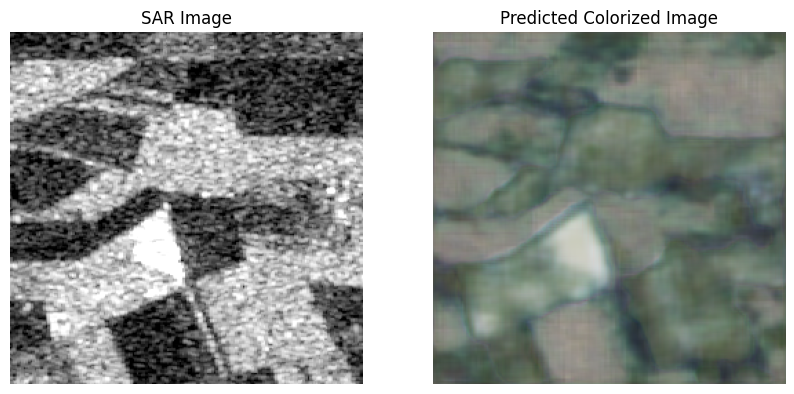

In [27]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_and_display(model, sar_image_path, image_size=(256, 256)):
    # Load and preprocess the SAR image
    sar_image = load_img(sar_image_path, target_size=image_size, color_mode='grayscale')
    sar_image = img_to_array(sar_image) / 255.0
    sar_image = np.expand_dims(sar_image, axis=0)  # Add batch dimension
    
    # Predict the colorized image
    predicted_image = model.predict(sar_image)
    predicted_image = np.squeeze(predicted_image, axis=0)  # Remove batch dimension

    # Display the SAR image and the predicted colorized image
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("SAR Image")
    plt.imshow(sar_image[0, :, :, 0], cmap='gray')  # Display the SAR image in grayscale
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Colorized Image")
    plt.imshow(predicted_image)
    plt.axis('off')

    plt.show()

# Example usage of the inference function
# Adjust the path to point to a specific SAR image within your Kaggle dataset
sar_test_image_path = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1/ROIs1868_summer_s1_59_p10.png"  # Change this to the actual image filename
predict_and_display(model, sar_test_image_path)


In [28]:
# Save the model after training
model.save('sar_optical_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


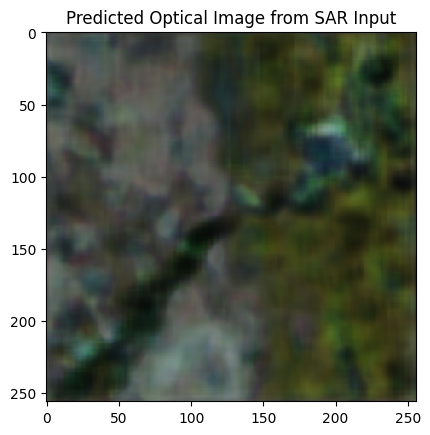

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Load the saved model
model = load_model('sar_optical_model.h5')

# Define the image preprocessing function
def preprocess_image(image_path, image_size=(256, 256), color_mode='grayscale'):
    # Load and preprocess the image
    image = load_img(image_path, target_size=image_size, color_mode=color_mode)
    image = img_to_array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Test inference with a sample SAR image path
sar_image_path = '/kaggle/input/testing-image-22/test.jpg'

# Preprocess the SAR image
sar_image = preprocess_image(sar_image_path)

# Make a prediction using the model
predicted_optical_image = model.predict(sar_image)

# Post-process the predicted image (if necessary)
predicted_optical_image = np.squeeze(predicted_optical_image)  # Remove batch dimension
predicted_optical_image = np.clip(predicted_optical_image, 0, 1)  # Ensure the pixel values are within [0, 1]

# You can visualize the predicted optical image using matplotlib
import matplotlib.pyplot as plt

plt.imshow(predicted_optical_image)
plt.title('Predicted Optical Image from SAR Input')
plt.show()
